<a id='Title-Language-Model'></a>
<h1 style="color:SlateGray;">Language Model</h1>

**Input image**

Any desired image, but most effective with images within the sizes 300x300 and 400x400.

**Output image**

The input image where values were maximized for the latter filters of Inception V3.

<h2 style="color:SlateGray;">Background</h2>

**Pre-trained models**

<a id='Pre-trained-models-Inception-V3'></a>
*Inception V3*

A general purpose image classification model.

Implemented as a series of consolidated branches, where each branch has variations in convolutional window size, stride steps, etc., thus learning slightly different patterns. These learned patterns are merged and the branching/merging continues until the model produces a final probability distribution for the 2048 original classes the model was trained on.

**Layers**

[*Dense*](01_Image_Classification.ipynb#Layers-Dense)

[*LSTM*](12_Basic_NLP_RNN.ipynb#Layers-LSTM)

**Activations**

[*softmax*](01_Image_Classification.ipynb#Activations-softmax)
		
**Optimizers**

[*rmsprop*](01_Image_Classification.ipynb#Optimizers-rmsprop)
		
**Loss functions**

[*categorical_crossentropy*](01_Image_Classification.ipynb#Loss-functions-categorical_crossentropy)

<h2 style="color:SlateGray;">Overview</h2>

Demonstrates the capabilities of text-generation with RNN-based models.

Uses a random snippet of text from the dataset as a seed to produce the initial probability distribution of possible next characters. This distribution is rescaled by a temperature, which indicates the amount of randomness-padding desired from the distribution, a next character is then selected and appended to the original seed which will be fed back into the model for the next prediction.


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [2]:
from keras.applications import inception_v3
from keras import backend as K

K.set_learning_phase(0)
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

87916544/87910968 [==============================] - 34s 0us/step


In [3]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [4]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [5]:
dream = model.input

grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [6]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [13]:
import numpy as np

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10.
base_image_path = 'original_photo_deep_dream.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Processing image shape (275, 489)
...Loss value at 0 : 1.733099
...Loss value at 1 : 2.2210343
...Loss value at 2 : 2.8653314
...Loss value at 3 : 3.5825372
...Loss value at 4 : 4.3314414
...Loss value at 5 : 5.029285
...Loss value at 6 : 5.744803
...Loss value at 7 : 6.4371963
...Loss value at 8 : 7.135116
...Loss value at 9 : 7.780376
...Loss value at 10 : 8.425995
...Loss value at 11 : 9.032421
...Loss value at 12 : 9.614993


c:\users\manny\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


Processing image shape (385, 685)
...Loss value at 0 : 3.2907665
...Loss value at 1 : 4.615121
...Loss value at 2 : 5.727438
...Loss value at 3 : 6.6351166
...Loss value at 4 : 7.516773
...Loss value at 5 : 8.366488
...Loss value at 6 : 9.119462
...Loss value at 7 : 9.820789


c:\users\manny\anaconda3\envs\tensorflow\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (540, 959)
...Loss value at 0 : 3.3003328
...Loss value at 1 : 4.4939823
...Loss value at 2 : 5.5176625
...Loss value at 3 : 6.4259334
...Loss value at 4 : 7.307911
...Loss value at 5 : 8.146196
...Loss value at 6 : 8.943093
...Loss value at 7 : 9.694429


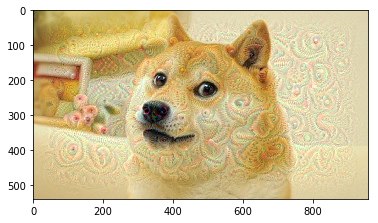

In [14]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()